# Business Understanding for the Movie Recommendation System
Objective:

The primary objective of the movie recommendation system is to enhance user engagement and satisfaction by providing personalized movie recommendations. By analyzing user behavior (movie ratings), the system will suggest movies that a user is likely to enjoy but has not yet watched. The recommendations will be based on the preferences of other users with similar tastes, improving the user's movie discovery experience.

## Business Context:


In today's entertainment industry, platforms like Netflix, Hulu, and Amazon Prime Video are flooded with vast movie collections. Users often find it overwhelming to sift through numerous titles to find content they would enjoy. Personalized recommendations address this problem by offering relevant movie suggestions, leading to higher customer satisfaction, increased engagement, and longer platform usage.

### For streaming platforms, delivering accurate and relevant recommendations is a critical business strategy because:

- Increased User Engagement: If users consistently find movies they enjoy, they will spend more time on the platform.
Reduced Churn Rate: Personalized content increases user loyalty, reducing the likelihood that users will unsubscribe from the service.

- Improved Content Discovery: Users can discover lesser-known or new movies, which broadens the diversity of the content they consume and reduces reliance on popular blockbusters.
Revenue Maximization: Higher engagement and satisfaction can translate into increased subscription renewals, lower churn rates, and a competitive advantage in the crowded streaming market.

### Key Metrics for Success:

- Recommendation Accuracy: Measured by evaluating the predicted movie ratings compared to actual user ratings, using metrics like RMSE (Root Mean Squared Error).

- User Engagement: The amount of time users spend on the platform after receiving recommendations (increased platform usage indicates higher engagement).



## How the System Works:
The system leverages collaborative filtering using the K-Nearest Neighbors (KNN) algorithm:

User-Item Matrix: The system is built on a user-item matrix where each user has rated a set of movies.

Similarity Calculation: For each target user, the system identifies other users with similar rating patterns (using cosine similarity).

Movie Recommendations: Based on the ratings of these "similar" users (neighbors), the system recommends movies that the target user hasn’t watched yet but is likely to enjoy.

### Benefits of Recommendation system to the Business:
1. The system can provide personalized recommendations to millions of users, improving customer satisfaction without manual intervention.

2. Higher Customer Lifetime Value: With relevant recommendations, users are more likely to continue using the service over a longer period, resulting in increased revenue per customer.

3. The system helps expose users to a broader range of content, reducing the focus on a few popular titles and improving overall content engagement.

### Challenges and Considerations:
- Cold Start Problem: New users with no rating history may not receive accurate recommendations initially.


- Data Sparsity: If many users rate only a small number of movies, it may be challenging to find similar users.

- Scalability: As the number of users and movies increases, the recommendation system must be optimized for performance and scalability.


## Data Understanding

In this project, we'll be dealing with 4 Datasets(ratings.csv, movies.csv, tags.csv, and link.csv) which we will manipulate.

### Features in the Datasets

- Users Id (userId_x) - Identity of the user.
- Movies Id (movieId) - Identity of the movies.
- Ratings (rating) - Actual rating of the movie
- Movie Metadata (title,genres) - Provide info about movies.
- Tags (tags) - Provide info about the movie
- Timestamp (timestamp_x,timestamp_y) - Represents what time rating was added.

### Importing libraries

Import essential libraries for building our recommendation system. Each library has a specific role:

- pandas and numpy are used for data manipulation.

- scikit-learn provides machine learning algorithms and tools like train_test_split and metrics.

- scipy.sparse helps with creating sparse matrices, which are efficient for large datasets.

- matplotlib is used for visualization if needed.

In [54]:
import pandas as pd       # To handle dataframes and datasets
import numpy as np        # To perform numerical operations
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.metrics.pairwise import cosine_similarity  # To compute similarity between items
from sklearn.metrics import mean_squared_error  # To calculate model accuracy (RMSE)
from scipy.sparse import csr_matrix  # For creating sparse matrices (efficient memory usage)
from sklearn.neighbors import NearestNeighbors  # KNN model for collaborative filtering
import matplotlib.pyplot as plt # For visualisation
import seaborn as sns  # For visualization

In [55]:
# Load datasets into DataFrames
df_ratings = pd.read_csv('ratings.csv')
df_movies = pd.read_csv('movies.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')

In [56]:
print(df_ratings.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [57]:
print(df_movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [58]:
print(df_tags.head())

   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200


In [59]:
print(df_links.head())

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0


### Data Preparation
 In this step, we will merge the dataset and load into one single DataFrame to simplify dealing with missing values,dropping duplicates and feature engineering.

In [60]:
# Merge the datasets on 'movieId'
df_merged = df_ratings.merge(df_movies, on='movieId', how='left') \
                       .merge(df_tags, on=['userId', 'movieId'], how='left') \
                       .merge(df_links, on='movieId', how='left')



In [61]:
#Inspecting the Dataframe
df_merged.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,114709,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN,113228,15602.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN,113277,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN,114369,807.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN,114814,629.0


In [62]:
#Summary of the DataFrame
print(df_merged.info())

#Inspect the shape of the data
print(df_merged.shape)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       102677 non-null  int64  
 1   movieId      102677 non-null  int64  
 2   rating       102677 non-null  float64
 3   timestamp_x  102677 non-null  int64  
 4   title        102677 non-null  object 
 5   genres       102677 non-null  object 
 6   tag          3476 non-null    object 
 7   timestamp_y  3476 non-null    float64
 8   imdbId       102677 non-null  int64  
 9   tmdbId       102664 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 8.6+ MB
None
(102677, 10)


Our Dataset merged contains 10 columns and 102677 rows.

In [63]:
#Inspecting missing values
df_merged.isnull().sum()

userId             0
movieId            0
rating             0
timestamp_x        0
title              0
genres             0
tag            99201
timestamp_y    99201
imdbId             0
tmdbId            13
dtype: int64

In [64]:
df_merged.describe()

,userId,movieId,rating,timestamp_x,timestamp_y,imdbId,tmdbId
count,102677.000000,102677.000000,102677.000000,1.026770e+05,3.476000e+03,1.026770e+05,102664.000000
mean,327.761933,19742.712623,3.514813,1.209495e+09,1.323525e+09,3.564994e+05,20476.871289
std,183.211289,35884.400990,1.043133,2.170117e+08,1.731554e+08,6.295717e+05,54097.633332
min,1.000000,1.000000,0.500000,8.281246e+08,1.137179e+09,4.170000e+02,2.000000
25%,177.000000,1199.000000,3.000000,1.019138e+09,1.138032e+09,9.971000e+04,710.000000
50%,328.000000,3005.000000,3.500000,1.186590e+09,1.279956e+09,1.188420e+05,6950.000000
75%,477.000000,8366.000000,4.000000,1.439916e+09,1.498457e+09,3.172480e+05,11673.000000
max,610.000000,193609.000000,5.000000,1.537799e+09,1.537099e+09,8.391976e+06,525662.000000


Our Dataset is loking pretty good since we have few columns with missing values.Since the 'tag' & 'timestamp_y' columns have a lot of missing values(90%), we can drop them as they provide insignificant information.

In [65]:
#Dropping 'tag' & 'timestamp_y' from our Data
df_merged.drop(['tag', 'timestamp_y'], axis=1, inplace=True)

In [66]:
#Filling 'tmbd' column with the mean
df_merged['tmdbId'].fillna(df_merged['tmdbId'].mean(), inplace=True)


In [67]:
df_merged.isnull().sum()

userId         0
movieId        0
rating         0
timestamp_x    0
title          0
genres         0
imdbId         0
tmdbId         0
dtype: int64

The dataset is now clean and we can now proceed with the feature engineering.

### Feature Engineering

In [68]:
#Dropping duplicates
df_merged.drop_duplicates(inplace=True)

In [69]:
#Year Extraction: Extract the year from the 'title' column.
df_merged['year'] = df_merged['title'].str.extract(r'\((\d{4})\)')
df_merged['year']

0         1995
1         1995
2         1995
3         1995
4         1995
          ... 
102672    2017
102673    2017
102674    2017
102675    2017
102676    2017
Name: year, Length: 100836, dtype: object

In [70]:
#Convert genres into a more usable format.
df_merged['genres'] = df_merged['genres'].str.split('|')
df_merged = df_merged.explode('genres')
df_merged.head()

,userId,movieId,rating,timestamp_x,title,genres,imdbId,tmdbId,year
0,1,1,4.0,964982703,Toy Story (1995),Adventure,114709,862.0,1995
0,1,1,4.0,964982703,Toy Story (1995),Animation,114709,862.0,1995
0,1,1,4.0,964982703,Toy Story (1995),Children,114709,862.0,1995
0,1,1,4.0,964982703,Toy Story (1995),Comedy,114709,862.0,1995
0,1,1,4.0,964982703,Toy Story (1995),Fantasy,114709,862.0,1995


### Performing Exploratory Data Analysis

#### Univariate

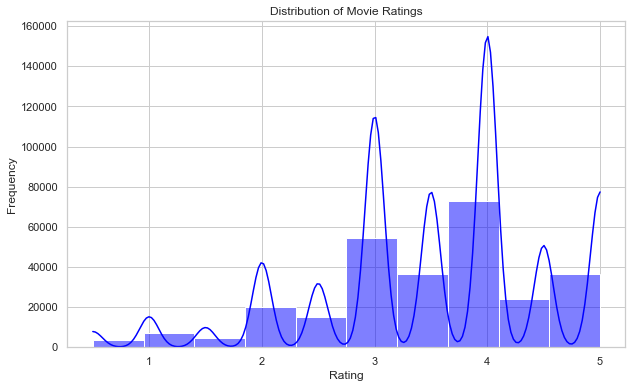

In [71]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(ticks=[i for i in range(1,6)])  # Assuming ratings are from 1 to 6
plt.show()

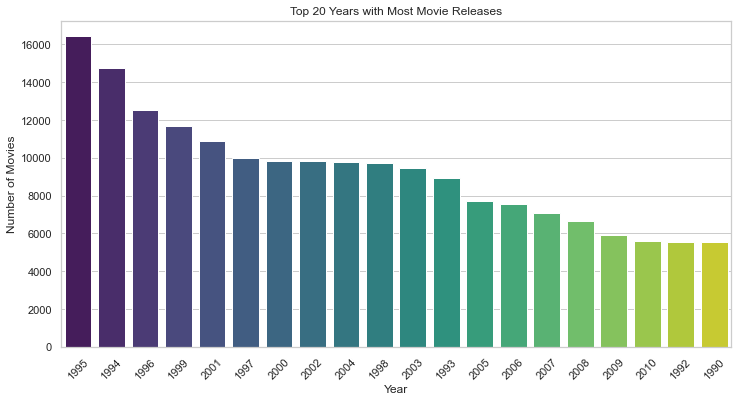

In [72]:
# Calculate the number of movies released per year
top_years = df_merged['year'].value_counts().nlargest(20)

# Plot the distribution of movies by year (top 20)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_years.index, y=top_years.values, palette='viridis')
plt.title('Top 20 Years with Most Movie Releases')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()


#### Bivariate Analysis
Relationship between two variables.

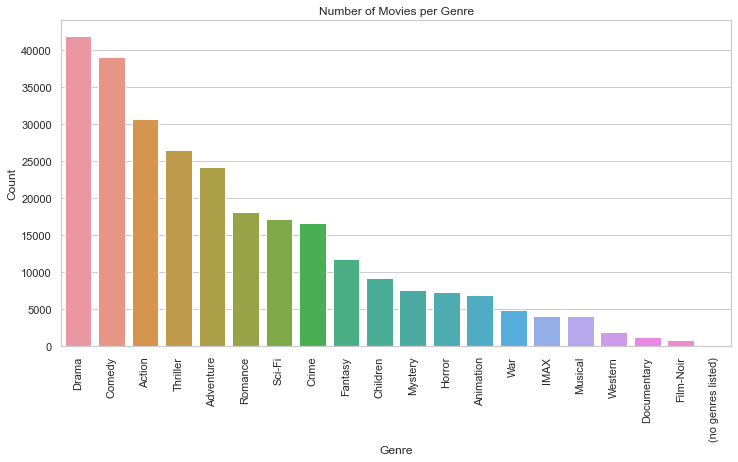

In [73]:
# Analyze the number of genreof movies per genre
plt.figure(figsize=(12, 6))
sns.countplot(x='genres', data=df_merged, order=df_merged['genres'].value_counts().index)
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

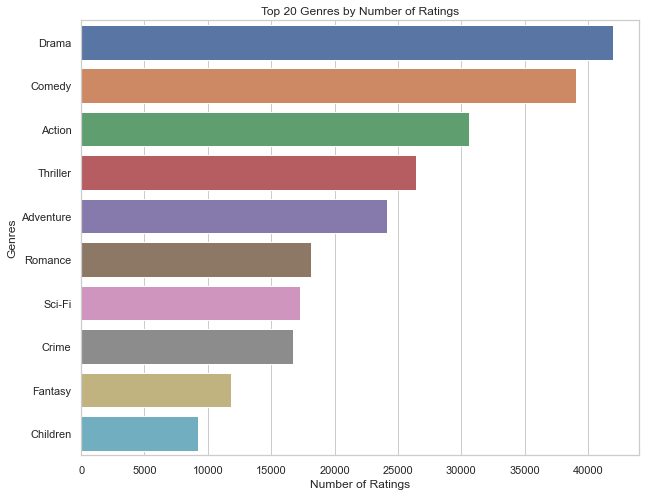

In [74]:
# Group by genre and count the number of ratings for each movie
df_genres_ratings = df_merged.groupby('genres')['rating'].count().sort_values(ascending=False).head(10)
genres_ratings_summary = pd.DataFrame({'genres': df_genres_ratings.index, 'rating_count': df_genres_ratings.values})
# Explore the relationship between the number of ratings and the average rating
plt.figure(figsize=(10, 8))

# Use the 'genres_ratings_summary' DataFrame, which includes both the rating counts and average ratings
sns.barplot(x='rating_count', y='genres', data=genres_ratings_summary)
plt.title('Top 20 Genres by Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Genres')
plt.show()

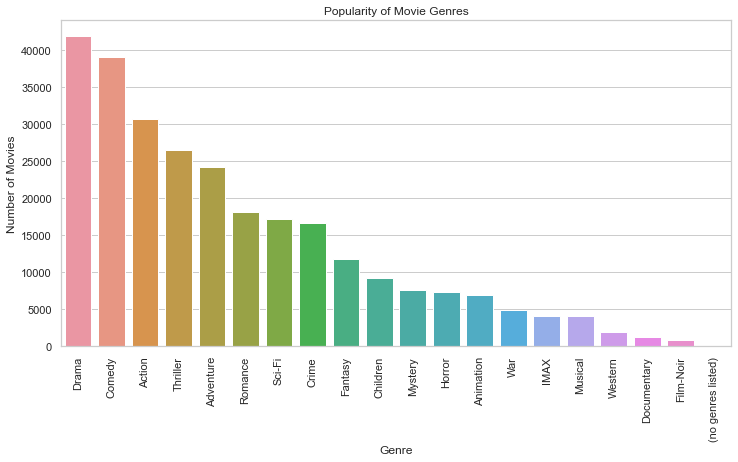

In [75]:
# Group by genre and count the number of movies in each genre
genre_popularity = df_merged.groupby('genres')['movieId'].count().sort_values(ascending=False)


# Plot the popularity of genres
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_popularity.index, y=genre_popularity.values)
plt.title('Popularity of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

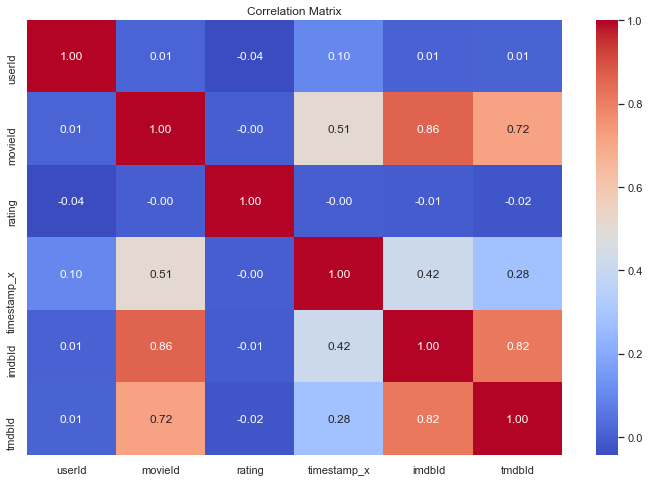

In [76]:
# Select only numeric columns from df_merged
numeric_df = df_merged.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


### Data Preprocessing
Prepare the data for building a recommendation system. The ratings and movies datasets are merged to create a movie_ratings DataFrame. Then, we pivot the data to get a user-movie matrix where rows represent users, columns represent movies, and the values represent ratings. Missing values are filled with 0 (indicating no rating given). Finally, we convert this matrix into a sparse matrix for memory efficiency.

In [77]:
# Create a user-item matrix
user_movie_matrix = df_merged.pivot_table(index='userId', columns='movieId', values='rating')

# Fill NaN values with 0 (meaning the user hasn't rated that movie)
user_movie_matrix = user_movie_matrix.fillna(0)

# Convert the user-item matrix to a sparse matrix for efficiency
sparse_user_movie= csr_matrix(user_movie_matrix.values)


+ pivot_table() creates the user-movie matrix where each user’s ratings for specific movies are stored.

+ fillna(0) replaces missing values (NaN) with 0.

+ csr_matrix stores the data more efficiently for matrix operations.

### Build Collaborative Filtering Model (KNN-Based)

Use the K-nearest neighbors (KNN) algorithm to find users who have similar preferences (similar movie ratings). We can later use this similarity to recommend movies. The metric used for similarity is cosine distance, which measures how similar two users' rating vect

In [78]:
# Create a NearestNeighbors model for collaborative filtering (using cosine similarity)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)

# Fit the model to the sparse user-item matrix
model_knn.fit(sparse_user_movie)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [79]:
# Example: Test with userId = 0 (first user), find 5 similar users
user_id = 0
distances, indices = model_knn.kneighbors(user_movie_matrix.iloc[user_id, :].values.reshape(1, -1), n_neighbors=6)

In [80]:
# Output the indices of similar users (excluding the first, which is the user itself)
print(f"Top 5 similar users to user {user_id}: {indices.flatten()[1:]}")

Top 5 similar users to user 0: [265 312 367  56  90]


+ NearestNeighbors creates a KNN model using cosine distance (for finding similar users).

+ kneighbors() finds the nearest users to a given user.

+ indices shows the most similar users to the input user.

### Generate Recommendations Based on Collaborative Filtering

Now that we’ve identified similar users, we aggregate their movie ratings to generate recommendations. The higher the mean rating from similar users, the more likely the movie will be recommended

In [81]:
# Extract ratings from similar users
similar_users = indices.flatten()[1:]  # Skip first index (the input user itself)
similar_users_ratings = user_movie_matrix.iloc[similar_users]

In [82]:
# Calculate mean ratings for each movie across the similar users
mean_ratings = similar_users_ratings.mean(axis=0)
mean_ratings

movieId
1         2.2
2         0.6
3         1.2
4         0.0
5         0.0
         ... 
193581    0.0
193583    0.0
193585    0.0
193587    0.0
193609    0.0
Length: 9724, dtype: float64

In [83]:
# Sort the mean ratings in descending order to recommend highest-rated movies
recommended_movies = mean_ratings.sort_values(ascending=False)

In [84]:
print(f"Top recommended movies for user {user_id}:")
print(recommended_movies)

Top recommended movies for user 0:
movieId
1200     4.8
1198     4.8
2571     4.8
2028     4.7
296      4.5
        ... 
53550    0.0
53519    0.0
53468    0.0
53466    0.0
7299     0.0
Length: 9724, dtype: float64


+ We calculate the mean rating for each movie across similar users.

+ Sort the movies by their average rating to find the highest-rated movies that can be recommended to the user.

### Build Content-Based Filtering System

In content-based filtering, we recommend movies based on their features (like genre and tags) rather than user preferences. Here, we combine the movie genres and tags into a single metadata feature for each movie, which we’ll use to calculate content similarity.

In [85]:
# Split movie genres into individual words
df_movies['genres'] = df_movies['genres'].str.split('|')

In [86]:
# Merge movies with tags (joining on movieId)
df_movies_with_tags = pd.merge(df_movies, df_tags, on='movieId', how='left')

In [87]:
# Replace NaN tags with empty strings
df_movies_with_tags['tag'].fillna('', inplace=True)

In [88]:
# Combine genres and tags into a single metadata column
#df_movies_with_tags['metadata'] = df_movies_with_tags['genres'].apply(lambda x: ' '.join(x)) + ' ' + df_movies_with_tags['tag']

# Ensure 'genres' is a list of strings
df_movies_with_tags['metadata'] = df_movies_with_tags['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)) + ' ' + df_movies_with_tags['tag'].fillna('')


In [89]:
# Vectorize the metadata using TF-IDF (Term Frequency-Inverse Document Frequency)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_movies_with_tags['metadata'])

In [90]:
# Compute cosine similarity between movies based on their metadata
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 1.        , 0.42714156, ..., 0.        , 0.27659812,
        0.17866863],
       [1.        , 1.        , 0.42714156, ..., 0.        , 0.27659812,
        0.17866863],
       [0.42714156, 0.42714156, 1.        , ..., 0.        , 0.27659812,
        0.17866863],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.27659812, 0.27659812, 0.27659812, ..., 0.        , 1.        ,
        0.        ],
       [0.17866863, 0.17866863, 0.17866863, ..., 0.        , 0.        ,
        1.        ]])

+ We split genres into separate terms and join the tags.

+ TF-IDF helps convert the text metadata (genres + tags) into numerical vectors.

+ Cosine similarity is computed to measure how similar movies are based on their content.

### Generate Recommendations Based on Content Similarity

Given a movie title, we use its cosine similarity score to recommend movies that have similar content (similar genres or tags).

In [91]:
# Define a function to recommend movies based on cosine similarity
def recommend_movies_based_on_content(movie_title):
    # Find the index of the given movie in the dataset
    idx = movies_with_tags[movies_with_tags['title'] == movie_title].index[0]

In [92]:


# Define a function to recommend movies based on cosine similarity
def recommend_movies_based_on_content(movie_title, cosine_sim=cosine_sim, df_movies_with_tags=df_movies_with_tags):
    try:
        # Find the index of the given movie in the dataset
        idx = df_movies_with_tags[df_movies_with_tags['title'] == movie_title].index[0]
        # Get similarity scores for the movie, sorted by highest score
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the top 10 most similar movies (excluding the movie itself)
        sim_scores = sim_scores[1:11]
        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]
        # Return the top 10 most similar movies
        return df_movies_with_tags['title'].iloc[movie_indices]
    except IndexError:
        print("Movie not found in the dataset.")
        return []

# Example: Recommend movies similar to "Toy Story (1995)"
movies = df_movies
tags = df_tags
recommendations = recommend_movies_based_on_content("Toy Story (1995)")
print(recommendations)


1                                     Toy Story (1995)
3214                                Toy Story 2 (1999)
3217                                Toy Story 2 (1999)
2484                              Bug's Life, A (1998)
8672                                         Up (2009)
2422                                       Antz (1998)
3753    Adventures of Rocky and Bullwinkle, The (2000)
3966                  Emperor's New Groove, The (2000)
4633                             Monsters, Inc. (2001)
7617                                  Wild, The (2006)
Name: title, dtype: object


In [93]:
# Example: Recommend movies similar to 'Toy Story (1995)'
similar_movies = recommend_movies_based_on_content('Toy Story (1995)')
print(f"Movies similar to 'Toy Story (1995)':\n{similar_movies}")

Movies similar to 'Toy Story (1995)':
1                                     Toy Story (1995)
3214                                Toy Story 2 (1999)
3217                                Toy Story 2 (1999)
2484                              Bug's Life, A (1998)
8672                                         Up (2009)
2422                                       Antz (1998)
3753    Adventures of Rocky and Bullwinkle, The (2000)
3966                  Emperor's New Groove, The (2000)
4633                             Monsters, Inc. (2001)
7617                                  Wild, The (2006)
Name: title, dtype: object


## Evaluation (RMSE Calculation)

We evaluate the performance of our collaborative filtering model using Root Mean Squared Error (RMSE), a common metric to measure prediction accuracy.

In [94]:
# Flatten actual and predicted values to calculate RMSE
actual = np.array(user_movie_matrix.iloc[user_id, :]).flatten()
predicted = np.array(mean_ratings).flatten()

In [95]:
# Filter out movies that the user has actually rated (ignoring zero ratings)
mask = actual > 0
rmse = np.sqrt(mean_squared_error(actual[mask], predicted[mask]))

In [96]:
# Print the RMSE score
print(f"RMSE for collaborative filtering: {rmse}")

RMSE for collaborative filtering: 3.1777174089327835


+ mean_squared_error calculates the squared difference between actual and predicted ratings.

+ RMSE is the square root of this error, providing a measure of accuracy.

- Model Accuracy

Good Fit: A low RMSE suggests that your model fits the data well, capturing the underlying patterns effectively.

Prediction Quality: It means that the differences between predicted and actual values (errors) are small. Therefore, your model is likely to make reliable predictions
